---
title: "Understanding Bayesian Thinking for Industrial Applications"
date: 2025-10-10
description: "Learn how Bayesian thinking can enhance decision-making in industrial applications. This article lay the foundation of bayesion modelling with Pymc and their practical use cases."

image: bayesion-01.jpg
twitter-card: 
    image: "posterior_sensitivity.svg"
open-graph: 
    image: "posterior_sensitivity.svg"

title-block-banner: true

categories:
  - python
  - bayesian

title-block-banner: "bayesion-01.jpg"
format:
  html:
    code-fold: true
    code-summary: "Show the code"
    code-overflow: wrap
    shift-heading-level-by: 1
    reference-location: margin
    quarto-template-params:
      banner-header-class: "blog-post"
---

## Introduction

A company has recently installed a new, expensive machine. A critical question arises: *How long will it last before failure*?. The lead engineer, drawing on experience with previous models, estimates a lifespan of approximately 10 years. However, only 3 months of real-world test data are available for this specific unit, and a major warranty and service contract decision must be made immediately.


This scenario exemplifies a common challenge in industrial applications: **making informed decisions with limited data**. Bayesian thinking offers a powerful framework to address such problems by combining prior knowledge with observed data to update our beliefs about uncertain parameters.

In this article, we will explore the fundamentals of Bayesian thinking and how it can be applied to industrial scenarios like the one described above. We will cover key concepts such as prior distributions, likelihood functions, and posterior distributions, and demonstrate how to implement Bayesian models using Python's [PyMC library]().

## The Building Blocks of Bayesian modeling

Traditional (Frequentist) statistics relies on large datasets the “long run” to produce confident conclusions, a limitation in industrial contexts where data are often sparse. New products, machines, or processes typically generate only small samples, while valuable expert knowledge such as an engineer’s lifespan estimate is excluded from conventional models. 

Bayesian inference overcomes these issues by combining **prior knowledge** with **new data**, enabling faster and more informed decisions when information is limited. This integration of expertise and evidence defines Bayesian thinking.




The process of updating our beliefs is formalized by Bayes' Theorem.
$$
P(\theta \mid D) = \frac{P(D \mid \theta) P(\theta)}{P(D)}
$$

While the formula looks mathematical, its components represent a beautifully intuitive learning cycle.

$$ 
\mathrm{Posterior} \propto \mathrm{Likelihood} \times \mathrm{Prior}
$$

Let us break down how this relates to our machine failure problem; where $\theta$ is the machine's expected failure rate, and $D$ is the 3 months of test data.

### Prior, Likelihood, and Posterior

1. **Prior** $P(\theta)$ represents the initial belief before observing any data. It incorporates domain expertise and historical knowledge. For instance, historical records may indicate that similar machines have an average lifespan of approximately ten years, implying a low failure rate. This prior belief defines the starting point for
𝜃 $\theta$. 

2. **Likelihood**  $P(D \mid \theta)$  quantifies the compatibility between the observed data and a given parameter value. It expresses the probability of observing the test outcomes for different possible failure rates. In this context, the likelihood measures how probable it is to observe zero failures within three months if the true average lifespan were, for example, five or fifteen years.


3. **Posterior**  $P(\theta \mid D)$  represents the updated belief after incorporating the observed data. It integrates prior knowledge with the evidence provided by the likelihood. In the machine-failure example, the posterior distribution expresses the updated estimate of expected lifespan after combining historical information (e.g., the ten-year prior) with the three months of failure-free operational data.


### PyMC: The Probabilistic Programming Engine
Understanding the relationship $\mathrm{Posterior} \propto \mathrm{Likelihood} \times \mathrm{Prior}$ is the conceptual heart of Bayesian analysis. However, calculating the actual posterior distribution, $ P(\theta \mid D) $, often involves complex, multi-dimensional integration that is impossible to solve analytically for real-world industrial problems. This challenge is addressed through Probabilistic Programming Languages (PPLs) such as PyMC.

[PyMC](https://www.pymc.io/welcome.html) is an open-source Python library for constructing and fitting Bayesian statistical models using advanced computational algorithms, including Markov Chain Monte Carlo (MCMC) and variational inference. It is one of several modern PPLs available in Python, alongside [Pyro](https://pyro.ai/) and [TensorFlow Probability (TFP)](https://www.tensorflow.org/probability). This tutorial focuses on PyMC due to its clarity, community support, and extensive documentation.

## Case study: A/B Testing with Small Samples

To shift from theory to practical implementation, we will apply the Bayesian building blocks Prior, Likelihood, and Posterior to a concrete industrial problem common in tech and e-commerce: A/B Testing

> Suppose you are a data scientist at an e-commerce company. The marketing team just launched a new website feature and wants to know:

 1. What's the true conversion rate?

 2. Is it better than the old version (which historically has an 8% conversion rate)?

 3. How much should we trust this estimate with limited data?

> During the first few days of the feature launch, the company has observed 200 visitors with only 15 conversion.



In [1]:
#import libraries
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
import pymc as pm
import arviz as az
import pandas as pd
import numpy as np
from IPython.display import clear_output
from great_tables import GT
import matplotlib.pyplot as plt
az.style.use("arviz-white")
from cycler import cycler
colors=['#107591','#f69a48','#00c0bf', '#fdcd49',"#cf166e", 
        "#7035b7", "#212121","#757575", "#E0E0E0","#FAFAFA"]
plt.rcParams.update({
    "figure.dpi": 100,
    "axes.labelsize": 12,
    "axes.titlesize": 12,
    "figure.titlesize": 12,
        "font.size": 12,
        "legend.fontsize": 12,
        "xtick.labelsize": 12,
        "ytick.labelsize": 12,
        "axes.linewidth" : 0.5,
        "lines.linewidth" : 1.,
        "legend.frameon" :False,
        'axes.prop_cycle': cycler(color=colors)
        
})
import altair 
altair.themes.enable('carbonwhite')
import altair as alt
alt.data_transformers.enable('default', max_rows=None)
clear_output()

In [2]:
# For reproducibility
np.random.seed(42)

# A/B Test Parameters
visitors = 200
conversions = 15
observed_conversion_rate = conversions / visitors
historical_baseline = 0.08


#### Define Prior, likelihood, and Posterior in PyMC

To model this problem in PyMC, one must first define the Prior and Likelihood distributions

**Prior**: Since the conversion rate $\theta$,  can only range between 0 and 1. The Beta distribution is ideal for modeling parameters that are bounded between 0 and 1, such as probabilities or rates.

The Beta distribution is controlled by two parameters, $\alpha$ and $\beta$. hese parameters are set to formally encode the prior knowledge: the historical 8% conversion rate. The mean of a $\mathrm{Beta}(\alpha,\beta)$ distribution is $\frac{\alpha}{ \alpha + \beta}$. Since the historical rate is 8% (or 0.08), we need to choose $\alpha$ and $\beta$ such that:
$$
\frac{\alpha}{ \alpha + \beta} = 0.08
$$

To determine the strength of this belief, a number that represents the effective sample size (ESS) of the historical knowledge is chosen. Choosing a hypothetical ESS of 100 trials, we can solve for $\alpha$ and $\beta$:
- ESS $= \alpha + \beta = 100$
- $\alpha$ (hypothetical successes) $=100×0.08=8$
- $\beta$ (hypothetical failures) $=100−8=92$

**Likelihood** the Likelihood is determined by the process that generated the data. Since there is a fixed number of trials (N=200 visitors) and the number of successes (k=15 conversions) is counted, this is a Binomial distribution.

In [3]:
with pm.Model() as conversion_model:
    # Prior distribution based on historical performance
    conversion_rate = pm.Beta("conversion_rate", alpha=8, beta=92)
    
    # Likelihood function
    likelihood = pm.Binomial("observations", n=visitors, p=conversion_rate, observed=conversions)
    
    # Sample from posterior distribution
    trace = pm.sample(2000, tune=1000, chains=4, random_seed=42, return_inferencedata=True)

clear_output()

This small block of code above defines and runs our entire Bayesian analysis. For those seeing PyMC for the first time, here is what each section is doing:

1.  `with pm.Model() as model:` This block acts as a container for all the random variables and data in our model. Everything inside this context belongs to the conversion_model
   
2. `conversion_rate = pm.Beta(...)`: We are telling PyMC that the true conversion_rate is a random variable, and our initial belief is described by the Beta(8,92) distribution.
   
3. `likelihood = pm.Binomial(...)`: This defines the process that generated our observed data. We link the conversion_rate parameter to the actual observed data (n=visitors, observed=conversions) using the appropriate Binomial distribution.
   
4. `pm.sample(...)`: This is where the magic happens! The pm.sample function runs the MCMC sampler (the computational engine) to combine the Prior and the Likelihood, effectively calculating the Posterior distribution. We ask the sampler to draw 2000 samples after a 1000-sample tuning period, running 4 independent chains to ensure reliable results.

## Model diagnostics

Running `pm.sample()` generates the raw output, but the job isn't done yet. Before we trust the results, we must perform Model Diagnostics to ensure our computational engine (the MCMC sampler) has worked correctly. The single most important diagnostic check is confirming Convergence.

### Model Convergencevergence 

In Bayesian inference, Markov Chain Monte Carlo (MCMC) methods are employed to sample from the complex posterior distribution. These samples are relied upon to accurately estimate quantities like the mean conversion rate or its credible interval.

**Convergence** is the guarantee that the MCMC chains have explored the entire distribution and are now producing samples that truly represent the target Posterior distribution, and are not just stuck in a starting location.

   > **Analogy**: Imagine trying to understand the shape of a deep, misty valley (the posterior). If your chains haven't converged, they might be stuck high up on a ridge, missing the true, deep center. Diagnostics are the tools we use to confirm the chains have found and are walking across the bottom of the true valley.

PyMC uses the supporting library [ArviZ](https://www.arviz.org/en/latest/) for standardizing and analyzing the results, which provides the following  diagnostics and plots

1. Trace Plots: Visual inspection of parameter samples across iterations.

    - Good trace plots look like *fuzzy caterpillars* with no trends or jumps.

2. R-hat (Gelman-Rubin Statistic): Measures how well multiple chains agree.

   - R-hat ≈ 1 means convergence.
   - R-hat > 1.01 suggests problems.

3. Effective Sample Size (ESS): Indicates how many independent samples you effectively have.

    - Low ESS means poor mixing or autocorrelation. Good ESS is typically > 200 per parameter.

The most efficient way to check convergence numerically is using the ArviZ summary function, specifically asking for the diagnostics `az.summary(trace, kind="diagnostics")`. Alternatively, `az.plot_trace(trace)` can be used to get a visual sense of convergence.



#### Example Diagnostic Output

In [4]:
diag_table=az.summary(trace, kind="diagnostics")[['ess_bulk', 'ess_tail', 'r_hat']]
GT(diag_table).tab_header(
    title="",
    subtitle="Conversion Rate Model"
).cols_label({
        'ess_bulk': 'ESS Bulk',
        'ess_tail': 'ESS Tail.',
        'r_hat': 'R-hat',
    })

GT(_tbl_data=                 ess_bulk  ess_tail  r_hat
conversion_rate    3966.0    5559.0    1.0, _body=<great_tables._gt_data.Body object at 0x118015ba0>, _boxhead=Boxhead([ColInfo(var='ess_bulk', type=<ColInfoTypeEnum.default: 1>, column_label='ESS Bulk', column_align='right', column_width=None), ColInfo(var='ess_tail', type=<ColInfoTypeEnum.default: 1>, column_label='ESS Tail.', column_align='right', column_width=None), ColInfo(var='r_hat', type=<ColInfoTypeEnum.default: 1>, column_label='R-hat', column_align='right', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x15ce4eb90>, _spanners=Spanners([]), _heading=Heading(title='', subtitle='Conversion Rate Model', preheader=None), _stubhead=None, _source_notes=[], _footnotes=[], _styles=[], _locale=<great_tables._gt_data.Locale object at 0x107ca3700>, _formats=[], _substitutions=[], _options=Options(table_id=OptionsInfo(scss=False, category='table', type='value', value=None), table_caption=OptionsInfo(scss=False, category='table', type='value', value=None), table_width=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_layout=OptionsInfo(scss=True, category='table', type='value', value='fixed'), table_margin_left=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_margin_right=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_background_color=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_additional_css=OptionsInfo(scss=False, category='table', type='values', value=[]), table_font_names=OptionsInfo(scss=False, category='table', type='values', value=['-apple-system', 'BlinkMacSystemFont', 'Segoe UI', 'Roboto', 'Oxygen', 'Ubuntu', 'Cantarell', 'Helvetica Neue', 'Fira Sans', 'Droid Sans', 'Arial', 'sans-serif']), table_font_size=OptionsInfo(scss=True, category='table', type='px', value='16px'), table_font_weight=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_style=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_color=OptionsInfo(scss=True, category='table', type='value', value='#333333'), table_font_color_light=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_border_top_include=OptionsInfo(scss=False, category='table', type='boolean', value=True), table_border_top_style=OptionsInfo(scss=True, category='table', type='value', value='solid'), table_border_top_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_top_color=OptionsInfo(scss=True, category='table', type='value', value='#A8A8A8'), table_border_right_style=OptionsInfo(scss=True, category='table', type='value', value='none'), table_border_right_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_right_color=OptionsInfo(scss=True, category='table', type='value', value='#D3D3D3'), table_border_bottom_include=OptionsInfo(scss=False, category='table', type='boolean', value=True), table_border_bottom_style=OptionsInfo(scss=True, category='table', type='value', value='solid'), table_border_bottom_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_bottom_color=OptionsInfo(scss=True, category='table', type='value', value='#A8A8A8'), table_border_left_style=OptionsInfo(scss=True, category='table', type='value', value='none'), table_border_left_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_left_color=OptionsInfo(scss=True, category='table', type='value', value='#D3D3D3'), heading_background_color=OptionsInfo(scss=True, category='heading', type='value', value=None), heading_align=OptionsInfo(scss=True, category='heading', type='value', value='center'), heading_title_font_size=OptionsInfo(scss=True, category='heading', type='px', value='125%'), heading_title_font_weight=OptionsInfo(scss=True, category='heading', type='value', value='initial'), heading_subtitle_font_size=OptionsInfo(s

This table immediately indicates that the model is reliable and ready for analysis


- (R_hat = 1.0,Goal Achieved): Since R_hat is exactly 1.0, this confirms that the four independent MCMC chains have fully converged and agree on the shape of the posterior distribution. The model is reliable.

- ESS bulk ​and ESS tail (3966.0 and 5559.0, Goal Achieved): Both effective sample sizes are significantly greater than the ≥400 minimum threshold. This means there are plenty of high-quality, effectively independent samples to accurately estimate the mean, mode, and credible intervals of the true conversion rate.

##### Visual Check: Trace Plots
While the numbers in the summary table are essential, visually inspecting the MCMC chains confirms the story.

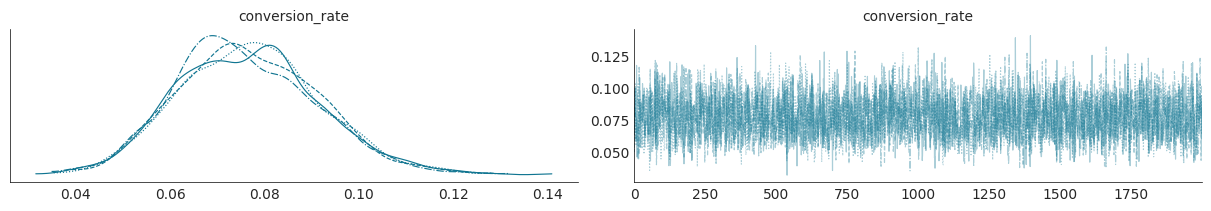

In [5]:
az.plot_trace(trace);

The trace plot above shows excellent convergence for our conversion rate ($\theta$) model, supporting the conclusions from our quantitative diagnostics. The plot is split into two panels
1. Right Panel: MCMC Sampling Behavior
    
   - This panel shows the raw sampled values across iterations for each of our four chains. The sampled values oscillate stably around ∼0.075 (7.5%) without any noticeable trends, sudden jumps, or long-term drifts. 
   - The different  lines (chains) are thoroughly intertwined and overlap completely. This "fuzzy caterpillar" appearance is the visual proof that the sampler is efficiently exploring the parameter space and that all chains have converged to the same distribution. 
   - The stable behavior confirms the chain has reached **stationarity**, meaning it is now sampling from the true, converged Posterior distribution.
2. Left Panel: Posterior Distribution

    - This panel shows the estimated Posterior probability density function (PDF) based on the samples. The shape is smooth and unimodal (single peak), indicating a well-behaved posterior without ambiguity.
    - The peak is clearly centered at a value close to our observed rate (7.5%), which is what we expect when combining a prior (8%) and data (7.5%).
    - The spread of the distribution clearly visualizes our remaining uncertainty about the true conversion rate.



## Prior Predictive Checks: Validating Model Assumptions

While we have demonstrated that the convergence of the fitted model a complete Bayesian analysis requires us to first validate the assumptions we made before seeing any data (priors). This validation is accomplished through the Prior Predictive Check.

> Prior Predictive Checks helps validate the prior assumptions before fitting the model to data. It  show what kind of data the model expects to generate based solely on the prior beliefs.

In [6]:
with pm.Model() as conversion_model:
    # Prior distribution based on historical performance
    conversion_rate = pm.Beta("conversion_rate", alpha=8, beta=92)
    
    # Likelihood function
    likelihood = pm.Binomial("observations", n=visitors, p=conversion_rate, observed=conversions)

Given our prior belief of an 8% conversion rate, we can simulate what kind of data we would expect to see if this belief were true. This is done by generating synthetic datasets from the prior distribution and comparing them to the actual observed data. This is acomplished in PyMC by running `pm.sample_prior_predictive()` function.

In [7]:
with conversion_model:
    prior_pred = pm.sample_prior_predictive()

Sampling: [conversion_rate, observations]


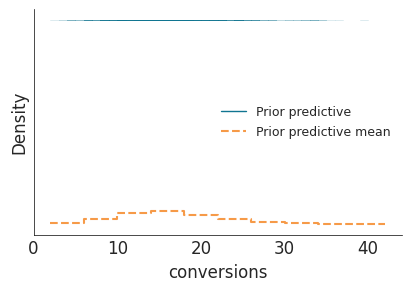

In [8]:
fig, ax=plt.subplots(figsize=(4, 2.8))
az.plot_ppc(prior_pred, group="prior", ax=ax)
plt.xlabel('conversions')
plt.ylabel('Density');

The generated plot from the prior predictive sampling shows the distributions of simulated data (the number of conversions) created by sampling from the $\text{Beta}(8,92)$ prior distribution.
- The distribution of the simulated data (prior predictive line) appear broadly spread out and relatively flat across a wide range (0 to 40+ conversions). This indicates that the prior allows for many different outcomes, and thus it is not overly restrictive.
- The dashed line  represents the average predicted number of conversions  It is also quite flat and non-committal.
- It evident that the prior predictive distribution does not overly concentrate around any specific number of conversions, which is desirable when we want to remain open to various possible outcomes.
- So the prior predictive check confirms that our chosen Beta(8,92) prior is reasonable though it also quite weakly informative how?

**Red flags to watch for:**
- **Impossible values**: Predictions outside the feasible range (e.g., negative conversion, >200 observations)
- **Unrealistic concentrations**: If priors are too informative, you might see all predictions clustered in a narrow range
- **Poor scaling**: Predictions that don't match the scale of your problem

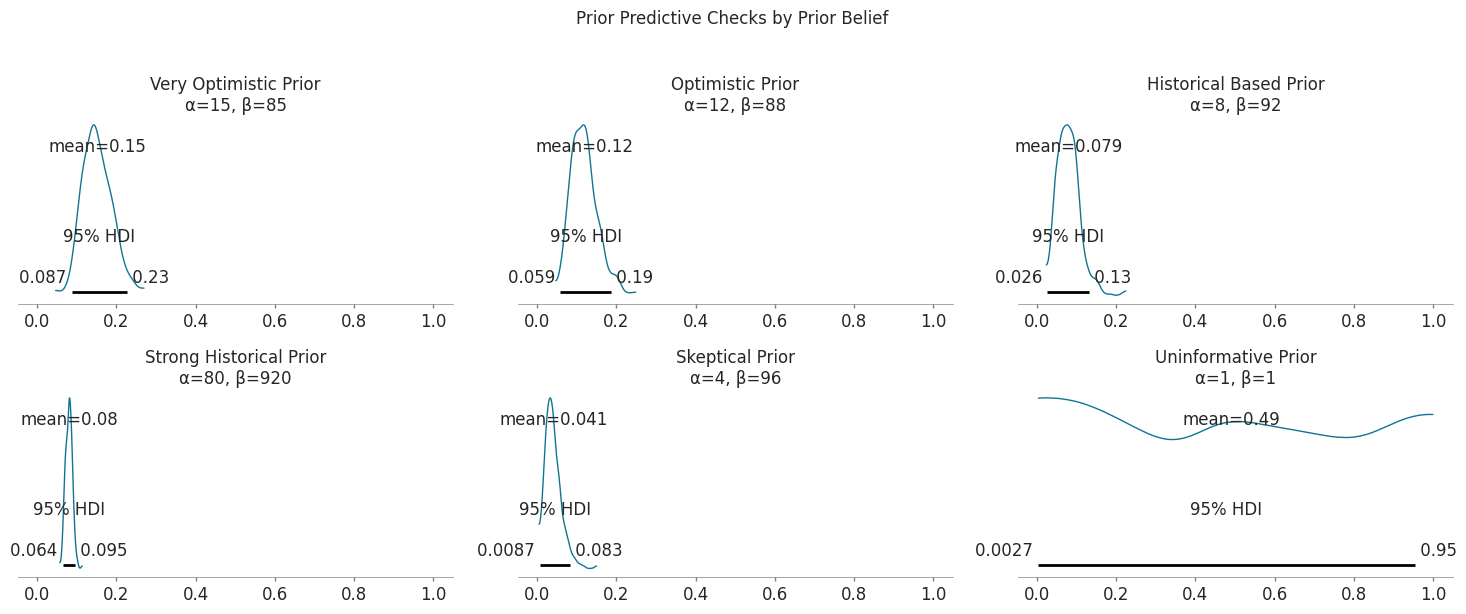

In [9]:
# Test different prior beliefs
priors_to_test = [
    ("Very Optimistic", 15, 85),    # Believes 15% conversion rate
    ("Optimistic", 12, 88),         # Believes 12% conversion rate  
    ("Historical Based", 8, 92),    # Our original prior (8%)
    ('Strong Historical', 80, 920),      # Mean = 0.08, ESS = 1000
    ("Skeptical", 4, 96),           # Believes 4% conversion rate
    ("Uninformative", 1, 1),        # Let data dominate completely
]

priors_df = pd.DataFrame()
fig, axes = plt.subplots(2, 3, figsize=(15, 6), sharex=True)
axes = axes.flatten()
for idx, (prior_name, alpha, beta) in enumerate(priors_to_test):
    with pm.Model() as sensitivity_model:
        conversion_rate = pm.Beta("conversion_rate", alpha=alpha, beta=beta)
        likelihood = pm.Binomial("observations", n=visitors, p=conversion_rate, observed=conversions)
        
    with sensitivity_model:
        prior_pred = pm.sample_prior_predictive()
    
    # Plot posterior
    df=pd.DataFrame({"Posterior":prior_pred.stack(sample=("chain", "draw")).prior['conversion_rate'],
                        "Prior":prior_name})
    priors_df=pd.concat([priors_df,df])
    
    #az.plot_ppc(prior_pred, group='prior',ax=axes[idx])
    az.plot_posterior(prior_pred, group='prior', ax=axes[idx], hdi_prob=0.95)
    axes[idx].set_title(f'{prior_name} Prior\nα={alpha}, β={beta}')
fig.suptitle('Prior Predictive Checks by Prior Belief', y=1.02)
plt.tight_layout()
clear_output()
plt.show()

In [10]:


domain = ["Very Optimistic", "Optimistic", "Historical Based", "Strong Historical", "Skeptical", "Uninformative"]
reference_data = pd.DataFrame([
    {'x': 0.08, 'label': 'Old Feature CR (8%)', 'color': 'red', 'label_x': 0.08},
    {'x': 0.075, 'label': 'New Feature CR (7.5%)', 'color': 'green', 'label_x': 0.075}
])
chart = alt.Chart(priors_df).transform_density(density='Posterior', groupby=['Prior'], as_=['Posterior', 'density'])\
    .mark_line(opacity=0.5)\
    .encode(x='Posterior:Q', 
            y='density:Q', 
            color=alt.Color("Prior:N").scale(domain=domain, range=colors[:len(domain)])
            )


reference_lines = alt.Chart(reference_data).mark_rule(
    strokeDash=[5, 5], # Dashed line
    size=1, 
).encode(
    x='x:Q',
    color=alt.Color('label:N', 
                    scale=alt.Scale(domain=reference_data['label'].tolist(), 
                                    range=reference_data['color'].tolist()),
                    legend=alt.Legend(title="Conversion Rate"))
)


final=chart + reference_lines 
final=final.properties(title='Prior Distributions by Prior Belief', width=900, height=300).configure_axis(
    # Set grid to False to remove all grid lines
    grid=False
).configure_view(
    # Optional: Remove the surrounding border of the plot area
    strokeWidth=0 
)
final

alt.LayerChart(...)

### Posterior Predictive Checks

Posterior Predictive Checks addresses the important test: Does the model actually make sense given the data observed?

This moves the process from confirming the samplers or priors to validating the model itself.

> PPCs evaluate model fit by comparing the observed data to simulated data from the posterior distribution. If a model accurately represents the data-generating process, the simulated data should resemble the actual observations.

To achive this it is important to generate new, simulated data from the posterior distribution and compare it to the actual observed data. This is done using the `pm.sample_posterior_predictive` function in PyMC.

In [11]:
with pm.Model() as conversion_model:
    # Prior distribution based on historical performance
    conversion_rate = pm.Beta("conversion_rate", alpha=8, beta=92)
    
    # Likelihood function
    likelihood = pm.Binomial("observations", n=visitors, p=conversion_rate, observed=conversions)
    
    # Sample from posterior distribution
    trace = pm.sample(2000, tune=1000, chains=4, random_seed=42, return_inferencedata=True)


with conversion_model:
    posterior_pred = pm.sample_posterior_predictive(trace, random_seed=42,)
    
clear_output()

In [12]:
ppc_summary = az.summary(posterior_pred, kind='stats', hdi_prob=0.95)
ppc_table = (
    GT(ppc_summary)
    .cols_label({
        'mean': 'Mean',
        'sd': 'Std-Dev.',
        'hdi_2.5%': 'HDI 3%',
        'hdi_97.5%': 'HDI 97%'
    }).tab_header(
        title="Posterior Predictive Summary Statistics",
        subtitle=""
    )
)
ppc_table 


GT(_tbl_data=                mean     sd  hdi_2.5%  hdi_97.5%
observations  15.314  4.806       6.0       24.0, _body=<great_tables._gt_data.Body object at 0x15cf506a0>, _boxhead=Boxhead([ColInfo(var='mean', type=<ColInfoTypeEnum.default: 1>, column_label='Mean', column_align='right', column_width=None), ColInfo(var='sd', type=<ColInfoTypeEnum.default: 1>, column_label='Std-Dev.', column_align='right', column_width=None), ColInfo(var='hdi_2.5%', type=<ColInfoTypeEnum.default: 1>, column_label='HDI 3%', column_align='right', column_width=None), ColInfo(var='hdi_97.5%', type=<ColInfoTypeEnum.default: 1>, column_label='HDI 97%', column_align='right', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x15eca3130>, _spanners=Spanners([]), _heading=Heading(title='Posterior Predictive Summary Statistics', subtitle='', preheader=None), _stubhead=None, _source_notes=[], _footnotes=[], _styles=[], _locale=<great_tables._gt_data.Locale object at 0x15edac310>, _formats=[], _substitutions=[], _options=Options(table_id=OptionsInfo(scss=False, category='table', type='value', value=None), table_caption=OptionsInfo(scss=False, category='table', type='value', value=None), table_width=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_layout=OptionsInfo(scss=True, category='table', type='value', value='fixed'), table_margin_left=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_margin_right=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_background_color=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_additional_css=OptionsInfo(scss=False, category='table', type='values', value=[]), table_font_names=OptionsInfo(scss=False, category='table', type='values', value=['-apple-system', 'BlinkMacSystemFont', 'Segoe UI', 'Roboto', 'Oxygen', 'Ubuntu', 'Cantarell', 'Helvetica Neue', 'Fira Sans', 'Droid Sans', 'Arial', 'sans-serif']), table_font_size=OptionsInfo(scss=True, category='table', type='px', value='16px'), table_font_weight=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_style=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_color=OptionsInfo(scss=True, category='table', type='value', value='#333333'), table_font_color_light=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_border_top_include=OptionsInfo(scss=False, category='table', type='boolean', value=True), table_border_top_style=OptionsInfo(scss=True, category='table', type='value', value='solid'), table_border_top_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_top_color=OptionsInfo(scss=True, category='table', type='value', value='#A8A8A8'), table_border_right_style=OptionsInfo(scss=True, category='table', type='value', value='none'), table_border_right_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_right_color=OptionsInfo(scss=True, category='table', type='value', value='#D3D3D3'), table_border_bottom_include=OptionsInfo(scss=False, category='table', type='boolean', value=True), table_border_bottom_style=OptionsInfo(scss=True, category='table', type='value', value='solid'), table_border_bottom_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_bottom_color=OptionsInfo(scss=True, category='table', type='value', value='#A8A8A8'), table_border_left_style=OptionsInfo(scss=True, category='table', type='value', value='none'), table_border_left_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_left_color=OptionsInfo(scss=True, category='table', type='value', value='#D3D3D3'), heading_background_color=OptionsInfo(scss=True, category='heading', type='value', value=None), heading_align=OptionsInfo(scss=True, category='heading', type='value', value='center'), heading_title_font_size=OptionsInfo(scss=True, category='heading', type='px', value='125%

It clear that the predicted mean (15.314) is extremely close to the actual observed count (15). This is a strong indication that the `conversion_rate model` fits the data very well. And thus the choice of the Beta Prior and Binomial Likelihood is appropriate for this data. The model predicts that 95% of the time, the number of conversions will fall between 6 and 24. Since the company observed value of 15 falls well within this 95% HDI, the actual observation is considered highly plausible according to your model.

In [13]:
ppc_samples = posterior_pred.posterior_predictive['observations'].values.flatten()
percentile = (ppc_samples <= conversions).mean() * 100
print(f"Observed convervation ({conversions}) is at the {percentile:.1f}th percentile of predictions")

Observed convervation (15) is at the 53.7th percentile of predictions


The value of 53.7 is very close to the ideal 50, which provides further strong evidence (in addition to the mean of 15.314 already seen) that:

- The model is not biased (it is not systematically over- or under-estimating the data).

- The choice of the Beta-Binomial model is highly appropriate for this data set.

## Model Utility and Business Decision

Following the confirmation of the reliability of the Bayesian model through the Posterior Predictive Check (PPC), the focus now shifts from "Does the model fit the data?" to the commercially critical question: "Is the model useful for making business decisions?"

Specifically, the derived posterior distribution is utilized to quantify the evidence that the new feature's conversion rate (Feature B) is superior to the existing, established conversion rate (Feature A, which has a known baseline rate of 0.08).

To achieve this, we need to extract the posterior distribution for the conversion_rate parameter that your model estimated.

In [14]:
posterior_samples = trace.posterior.stack(sample=("chain", "draw"))
conversion_samples=posterior_samples['conversion_rate'].values

Next, calculate the "probability of superiority"—the probability that the new feature (B) is better than the old (A).

Finally, the expected uplift in conversion rate can be computed and translated into business value. This involves calculating the difference between the posterior mean conversion rate and the historical rate, then multiplying by the number of visitors and average revenue per conversion.

- 0.95: Strong Evidence. The new feature is very likely superior. Launching it should be considered.

- 0.80: Moderate Evidence. The new feature is likely better, but there is still a 20% chance it is worse. The decision depends on company risk tolerance.

- 0.50: No Evidence. The new feature is a toss-up; there is no statistical reason to prefer it over the old feature.

In [15]:
prob_superiority = (conversion_samples > historical_baseline).mean()
# Display the result
print(f"The probability that the new feature is better than the old rate (0.08) is: {prob_superiority:.1%}")

The probability that the new feature is better than the old rate (0.08) is: 39.7%


The calculated Probability of Superiority is approximately 0.40, indicating that there is a 40% chance the new feature's conversion rate is better than the old feature's with 8% rate. This imply that there is a 60.3% chance the new feature is worse than the baseline.

Since the probability that the new feature is superior is well below the neutral benchmark of 50%, the data does not support replacing the existing Feature A with the new Feature B based on conversion rate alone. The new feature is highly likely to perform worse.

#### Probability of Meaningful Improvement.
Depending on the business context, one might also want to calculate the probability that the new feature is better by a meaningful margin (e.g., >1% improvement). This calculates the chance that the new feature is better than the old feature by a practically significant margin of at least 1 percentage point. This is a crucial business metric. Sometimes a tiny statistical "win" is not worth the cost of development and deployment. If this probability is low, it confirms the feature is not a major improvement.


In [16]:
prob_1pct_improvement = (conversion_samples > historical_baseline+0.01).mean()
print(f" Probability of >1% improvement: {prob_1pct_improvement:.1%}")

 Probability of >1% improvement: 18.4%


### Probability of Hitting a Target Rate

This calculates the chance that the true conversion rate of the new feature is 10% or higher. This is useful if 10% is a specific, ambitious KPI (Key Performance Indicator) or goal set by the marketing or product team. It tells how likely the team is to meet its goal.

In [17]:
prob_10pct = (conversion_samples > 0.10).mean()
print(f" Probability of >10% improvement: {prob_10pct:.1%}")

 Probability of >10% improvement: 6.3%


#### Expected Value of the Change.
This is the single-number best estimate of the average change (positive or negative) to expect upon deploying the new feature. This is the foundation for the "Expected Business Impact" section. If this value is negative, it represents an Expected Loss. 

If one calculates: expected_uplift×Total Visitors×ARPC, the estimated dollar value of the change is obtained.

The goal is to translate the statistically determined average change in conversion rate into a clear financial outcome for the business. This calculation provides the most actionable insight for the go/no-go decision on the new feature.


In [18]:
# Calculate key business probabilities
expected_uplift = conversion_samples.mean() - historical_baseline

# Calculate expected business impact
monthly_visitors = 10000
expected_additional_conversions = monthly_visitors * expected_uplift
conversion_value = 50  # Average value per conversion
expected_monthly_value = expected_additional_conversions * conversion_value

print(f"Expected uplift: {expected_uplift:.3f} ({expected_uplift:.1%} points)")
print(f"Expected monthly value: ${expected_monthly_value:,.0f}")


Expected uplift: -0.003 (-0.3% points)
Expected monthly value: $-1,717




We see that the expected uplift is -0.030 (-3.0% points), indicating that, on average, the new feature is expected to decrease the conversion rate by 3 percentage points. The expected financial consequence of deploying the new feature is a loss of $1,717 per month

The data suggests that deploying the new feature would likely result in an Expected Monthly Loss of $1,717. This financial quantification is the most compelling reason to reject the new feature based on conversion rate performance.

The decision to proceed should only be considered if the feature provides other, unquantified benefits (e.g., improved customer retention, compliance, or brand value) that are estimated to be worth more than $1,717 per month.

### Prior sensitivity analysis
Assessing how the **choice of prior influences the final decision** is important. This transparency is a key strength of **Bayesian modeling**, as it allows testing every assumption. Thus, one must determine how much the choice of prior affects the outcome by comparing several **Beta priors**. These comparisons will include priors from very optimistic (expecting a $15\%$ conversion rate) to skeptical (expecting only $4\%$), plus an **uninformative prior** that lets the data speak entirely for itself.

In [19]:

priors_to_test = [
    ("Very Optimistic", 15, 85),    # Believes 15% conversion rate
    ("Optimistic", 12, 88),         # Believes 12% conversion rate  
    ("Historical Based", 8, 92),    # Our original prior (8%)
    ('Strong Historical', 80, 920),      # Mean = 0.08, ESS = 1000
    ("Skeptical", 4, 96),           # Believes 4% conversion rate
    ("Uninformative", 1, 1),        # Let data dominate completely
]

sensitivity_results = []
traces_to_comprare = []

for idx, (prior_name, alpha, beta) in enumerate(priors_to_test):
    with pm.Model() as model:
        conversion_rate = pm.Beta("conversion_rate", alpha=alpha, beta=beta)
        obs = pm.Binomial("observations", n=visitors, p=conversion_rate, observed=conversions)
        trace = pm.sample(2000, tune=1000, chains=4, random_seed=42, return_inferencedata=True, progressbar=False)
        
 
    posterior_samples = trace.posterior.stack(sample=("chain", "draw"))
    conversion_samples=posterior_samples['conversion_rate'].values
    expected_uplift = conversion_samples.mean() - historical_baseline
    expected_additional_conversions = monthly_visitors * expected_uplift
    expected_monthly_value = expected_additional_conversions * conversion_value


    posterior_mean = conversion_samples.mean()
    posterior_std = conversion_samples.std()
    prior_std = np.sqrt((alpha * beta) / ((alpha + beta)**2 * (alpha + beta + 1)))
    prob_better = (conversion_samples > historical_baseline).mean()
    uncertainty_reduction = max(0, (prior_std - posterior_std) / prior_std)
    
    df = pd.DataFrame({"Prior": prior_name,
                       "Posterior": conversion_samples}
                       )
    
    sensitivity_results.append({
        'Prior_Belief': prior_name,
        'Prior_Parameters': f"Beta({alpha}, {beta})",
        'Prior_Mean': f"{alpha/(alpha+beta):.3f}",
        'Posterior_Mean': f"{posterior_mean:.3f}",
        'Prob_Better': f"{prob_better:.1%}",
        "Expected_uplift": f"${expected_uplift:.1%}",
        "Expected_monthly_value": f"${expected_monthly_value:,.0f}",
        'Uncertainty_Reduction': f"{uncertainty_reduction:.1%}",
        'Data_Influence': 'Strong' if uncertainty_reduction > 0.8 else 'Moderate'
    })
    traces_to_comprare.append(df) 
sensitivity_df = pd.DataFrame(sensitivity_results)
traces_to_comprare=pd.concat(traces_to_comprare)
clear_output()



Let first visualise the different priors

In [22]:


chart = alt.Chart(traces_to_comprare).transform_density(density='Posterior', groupby=['Prior'], as_=['Posterior', 'density'])\
    .mark_line(opacity=0.5)\
    .encode(x='Posterior:Q', 
            y='density:Q', 
            color=alt.Color("Prior:N").scale(domain=domain, range=colors[:len(domain)])
            )


reference_lines = alt.Chart(reference_data).mark_rule(
    strokeDash=[5, 5], # Dashed line
    size=1, 
).encode(
    x='x:Q',
    color=alt.Color('label:N', 
                    scale=alt.Scale(domain=reference_data['label'].tolist(), 
                                    range=reference_data['color'].tolist()),
                    legend=alt.Legend(title="Conversion Rate"))
)


final=chart + reference_lines 
final=final.properties(title='Posterior Distributions by Prior Belief', width=700, height=200).configure_axis(
    # Set grid to False to remove all grid lines
    grid=False
).configure_view(
    # Optional: Remove the surrounding border of the plot area
    strokeWidth=0 
)
final.save('posterior_sensitivity.pdf')
final

alt.LayerChart(...)

The figure above show Posterior belief distributions under different prior assumptions. Despite large differences in prior expectations, the posteriors converge near 8–9%, indicating strong data-driven stability. Each curve in the figure represents a posterior distribution for the conversion rate under a different prior assumption. The horizontal axis shows possible conversion rates, and the vertical axis shows how plausible each value is after combining the prior belief with the observed data. 

To support decision-making, we compile a summary table comparing key metrics across these prior choices.

In [21]:
# Create sensitivity analysis table
sensitivity_table = (
    GT(sensitivity_df)
    .tab_header(
        title="Sensitivity Analysis: Impact of Prior Beliefs",
        subtitle="How Different Starting Assumptions Affect Final Conclusions"
    )
    .cols_label(
        Prior_Belief="Prior Belief",
        Prior_Parameters="Prior Distribution", 
        Prior_Mean="Prior Mean",
        Posterior_Mean="Posterior Mean",
        Prob_Better="Prob. Better",
        Data_Influence="Data Influence",
        Uncertainty_Reduction="Uncertainty Reduction",
        Expected_uplift="Expected Uplift",
        Expected_monthly_value="Expected Monthly Value"
    )
    .data_color(
        columns=["Prob_Better"],
        palette=["#C73E1D", "#F18F01", "#2E8B57"],
        domain=[0.0, 0.5, 1.0]
    )
    .data_color(
        columns=["Data_Influence"],
        palette=["#2E8B57", "#F18F01", "#C73E1D"],
        domain=["Strong", "Moderate", "Weak"]
    ).data_color(
        columns=["Uncertainty Reduction"],
        palette=["#C73E1D", "#F18F01", "#2E8B57"],
        domain=[0.0, 80, 100]
    ).tab_source_note(
        "Analysis shows robustness of conclusions to different prior assumptions • "
        "Even skeptical priors converge toward data-driven truth"
    )
    .tab_options(
        table_width="100%",
    )
)
clear_output()
sensitivity_table

GT(_tbl_data=        Prior_Belief Prior_Parameters Prior_Mean Posterior_Mean Prob_Better  \
0    Very Optimistic     Beta(15, 85)      0.150          0.100       88.2%   
1         Optimistic     Beta(12, 88)      0.120          0.090       71.0%   
2   Historical Based      Beta(8, 92)      0.080          0.077       39.7%   
3  Strong Historical    Beta(80, 920)      0.080          0.079       47.3%   
4          Skeptical      Beta(4, 96)      0.040          0.064       11.8%   
5      Uninformative       Beta(1, 1)      0.500          0.079       44.8%   

  Expected_uplift Expected_monthly_value Uncertainty_Reduction Data_Influence  
0           $2.0%                 $9,930                 52.2%       Moderate  
1           $1.0%                 $4,992                 49.1%       Moderate  
2          $-0.3%                $-1,717                 44.1%       Moderate  
3          $-0.1%                  $-263                 10.4%       Moderate  
4          $-1.6%                $-8,231                 29.0%       Moderate  
5          $-0.1%                  $-456                 93.5%         Strong  , _body=<great_tables._gt_data.Body object at 0x15f9be770>, _boxhead=Boxhead([ColInfo(var='Prior_Belief', type=<ColInfoTypeEnum.default: 1>, column_label='Prior Belief', column_align='left', column_width=None), ColInfo(var='Prior_Parameters', type=<ColInfoTypeEnum.default: 1>, column_label='Prior Distribution', column_align='left', column_width=None), ColInfo(var='Prior_Mean', type=<ColInfoTypeEnum.default: 1>, column_label='Prior Mean', column_align='right', column_width=None), ColInfo(var='Posterior_Mean', type=<ColInfoTypeEnum.default: 1>, column_label='Posterior Mean', column_align='right', column_width=None), ColInfo(var='Prob_Better', type=<ColInfoTypeEnum.default: 1>, column_label='Prob. Better', column_align='right', column_width=None), ColInfo(var='Expected_uplift', type=<ColInfoTypeEnum.default: 1>, column_label='Expected Uplift', column_align='right', column_width=None), ColInfo(var='Expected_monthly_value', type=<ColInfoTypeEnum.default: 1>, column_label='Expected Monthly Value', column_align='right', column_width=None), ColInfo(var='Uncertainty_Reduction', type=<ColInfoTypeEnum.default: 1>, column_label='Uncertainty Reduction', column_align='right', column_width=None), ColInfo(var='Data_Influence', type=<ColInfoTypeEnum.default: 1>, column_label='Data Influence', column_align='left', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x15f65a950>, _spanners=Spanners([]), _heading=Heading(title='Sensitivity Analysis: Impact of Prior Beliefs', subtitle='How Different Starting Assumptions Affect Final Conclusions', preheader=None), _stubhead=None, _source_notes=['Analysis shows robustness of conclusions to different prior assumptions • Even skeptical priors converge toward data-driven truth'], _footnotes=[], _styles=[StyleInfo(locname=LocBody(columns='Prob_Better', rows=[0], mask=None), grpname=None, colname='Prob_Better', rownum=0, colnum=None, styles=[CellStyleText(color='#000000', font=None, size=None, align=None, v_align=None, style=None, weight=None, stretch=None, decorate=None, transform=None, whitespace=None), CellStyleFill(color='#808080')]), StyleInfo(locname=LocBody(columns='Prob_Better', rows=[1], mask=None), grpname=None, colname='Prob_Better', rownum=1, colnum=None, styles=[CellStyleText(color='#000000', font=None, size=None, align=None, v_align=None, style=None, weight=None, stretch=None, decorate=None, transform=None, whitespace=None), CellStyleFill(color='#808080')]), StyleInfo(locname=LocBody(columns='Prob_Better', rows=[2], mask=None), grpname=None, colname='Prob_Better', rownum=2, colnum=None, styles=[CellStyleText(color='#000000', font=None, size=None, align=None, v_align=None, style=None, weight=None, stretch=None, decorate=None, transform=None, whitespace=None), CellStyleFill(color='#808080')]), StyleInfo(locname=LocBody(columns='Prob_Better', rows=[3], mask=None), grpname=Non

Despite very different starting assumptions, the posterior estimates converge around 7–10%, showing that the data provide a stable, consistent signal largely independent of the chosen prior. All reasonable priors converge to the same conclusion: **the new feature likely isn't better than the old one**.

Key observations:

1. **Prior Pull**: The data moderate extreme beliefs. The very optimistic prior (0.150) is pulled down to 0.100, while the skeptical prior (0.040) rises to 0.064—demonstrating how new evidence shifts expectations toward a central value.

2. **Prior Strength vs. Data Influence:** The Strong Historical prior (Beta(80, 920)) and Uninformative prior (Beta(1, 1)) yield similar posteriors (~0.079, ~45% Prob_Better), but for opposite reasons. The former is dominated by prior belief; the latter, by data—showing that strong evidence can overcome weak or missing priors.

3. **Impact on Decision Metrics:**: The Very Optimistic prior suggests an 88% Prob_Better and +$9.9k expected value, favoring a launch. The Skeptical prior predicts only 12% Prob_Better and –$8.2k, suggesting the opposite. Even moderate priors (e.g., 40–47%) could tip a go/no-go decision depending on the threshold.


## Common Bayesian Pitfalls and Best Practices

While Bayesian modeling provides a powerful framework for decision-making under uncertainty, several common mistakes can reduce its effectiveness. 
> The first is overconfident priors, where excessively strong prior assumptions prevent new data from influencing the results. This issue is best mitigated by starting with weak or moderately informative priors and refining them as more evidence becomes available.

> A second pitfall is ignoring prior sensitivity. Conclusions may shift significantly depending on the chosen prior distribution, so it is essential to conduct sensitivity analyses using multiple plausible priors to ensure that insights are robust.

> The third major issue involves misinterpreting probability. A statement such as “95% probability” does not imply absolute certainty; rather, it reflects the degree of belief given the available data and assumptions. Probabilities in Bayesian analysis are best interpreted in terms of relative confidence, risk, and decision trade-offs.

To support rigorous implementation, the following checklist outlines a systematic workflow for Bayesian business analysis: 
1. Define a clear decision or research question, 
2. Collect relevant historical information to inform priors, 
3. Select an appropriate likelihood function, 
4. Test alternative prior specifications, 
5. Run the model and verify diagnostics, 
6. Interpret outcomes within the business or operational context, and communicate uncertainty transparently to stakeholders.

## Next Steps in the Bayesian Journey

This lesson introduced the foundations of Bayesian modeling as a framework for decision-making under uncertainty—an approach that integrates prior expertise with limited data to inform critical business and industrial decisions. The next stage is to translate these principles into practical applications.

The upcoming session will demonstrate how to apply the Bayesian framework to model time-to-failure for machines and customer retention durations. It will also explore methods for capturing patterns across naturally grouped data, such as regions, product lines, or customer segments.




## Resources to Continue Learning:
- [Bayesian Methods for Hackers](https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers)
- [Statistical Rethinking](https://xcelab.net/rm/statistical-rethinking/)
- [Doing Bayesian Data Analysis](https://www.taylorfrancis.com/books/mono/10.1201/9781315372495/doing-bayesian-data-analysis-john-kruschke)
- [Bayesian Data Analysis](http://www.stat.columbia.edu/~gelman/book/)
- [PyMC Documentation](https://www.pymc.io/welcome.html)